<a href="https://colab.research.google.com/github/NHidden/resorvior/blob/master/rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set colab setting

In [0]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

TensorFlow 2.x selected.
Note: using Google CoLab


Read data

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# PyDrive Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# link = 'https://drive.google.com/open?id=1ZXEnVsvmHaBFkquSlim12QPjg0a0rRhV' # reservoir.csv
link = 'https://drive.google.com/open?id=1uKyvYkNG6dEOul8wMO7EDkE0kyKkZC0j' # data_month

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')

1uKyvYkNG6dEOul8wMO7EDkE0kyKkZC0j


Import libraries

In [0]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

Data pre-processe

In [0]:
#read csv
DF = pd.read_csv('Filename.csv',na_values={"Err","null"})

# features_considered = ['date','pump(kW)','T(kg/ cm^3)','V1(%)','Q1(m^3/h)']
features_considered = ['pump(kW)','T(kg/ cm^3)','V1(%)','Q1(m^3/h)','V2(%)','Q2(m^3/h)','V4(%)','Q4(m^3/h)','Q(m^3/h)']
dataset = DF[features_considered]
dataset.columns = ['pump','T','V1','Q1','V2','Q2','V4','Q4','Q']
dataset = dataset.dropna(how='any')
display(dataset.head())
values = dataset.values

,pump,T,V1,Q1,V2,Q2,V4,Q4,Q
0,118.145110,7.193411,0.0,0.0,14.000000,346.933889,0.0,0.0,335.768611
1,116.454353,7.194838,0.0,0.0,14.000000,344.735556,0.0,0.0,328.933889
2,117.052692,7.192415,0.0,0.0,14.000000,337.132222,0.0,0.0,327.264444
3,115.434825,7.193366,0.0,0.0,14.000000,341.099167,0.0,0.0,335.000000
4,115.842131,7.193574,0.0,0.0,13.999174,344.198333,0.0,0.0,334.669444


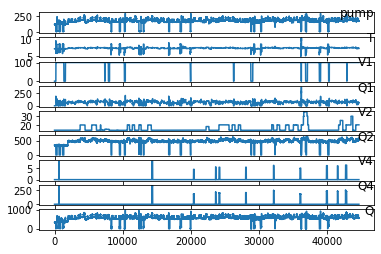

In [0]:
# specify columns to plot
groups = range(0,9)
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
# pyplot.show()

# convert series to supervised learning

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Standarlization

In [0]:
n_hours = 60
n_features = 8

values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.head())

    var1(t-60)  var2(t-60)  var3(t-60)  ...  var7(t)  var8(t)   var9(t)
60    0.401208    0.419575         0.0  ...      0.0      0.0  0.339584
61    0.395466    0.419828         0.0  ...      0.0      0.0  0.337775
62    0.397498    0.419398         0.0  ...      0.0      0.0  0.342315
63    0.392004    0.419567         0.0  ...      0.0      0.0  0.330681
64    0.393387    0.419604         0.0  ...      0.0      0.0  0.337707

[5 rows x 549 columns]




---
#LSTM


split into train and test sets

In [0]:
# split into train and test sets
values = reframed.values
n_train_size = int(len(dataset) * 0.67)
train = values[:n_train_size, :]
test = values[n_train_size:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(29908, 480) 29908 (29908,)
(29908, 60, 8) (29908,) (14672, 60, 8) (14672,)


design network

Train on 29908 samples, validate on 14672 samples
Epoch 1/20
29908/29908 - 10s - loss: 0.0486 - val_loss: 0.0278
Epoch 2/20
29908/29908 - 2s - loss: 0.0320 - val_loss: 0.0421
Epoch 3/20
29908/29908 - 2s - loss: 0.0282 - val_loss: 0.0209
Epoch 4/20
29908/29908 - 2s - loss: 0.0254 - val_loss: 0.0202
Epoch 5/20
29908/29908 - 2s - loss: 0.0237 - val_loss: 0.0267
Epoch 6/20
29908/29908 - 2s - loss: 0.0226 - val_loss: 0.0311
Epoch 7/20
29908/29908 - 2s - loss: 0.0196 - val_loss: 0.0434
Epoch 8/20
29908/29908 - 2s - loss: 0.0184 - val_loss: 0.0371
Epoch 9/20
29908/29908 - 2s - loss: 0.0176 - val_loss: 0.0381
Epoch 10/20
29908/29908 - 2s - loss: 0.0165 - val_loss: 0.0381
Epoch 11/20
29908/29908 - 2s - loss: 0.0175 - val_loss: 0.0354
Epoch 12/20
29908/29908 - 2s - loss: 0.0161 - val_loss: 0.0238
Epoch 13/20
29908/29908 - 2s - loss: 0.0156 - val_loss: 0.0325
Epoch 14/20
29908/29908 - 2s - loss: 0.0152 - val_loss: 0.0375
Epoch 15/20
29908/29908 - 2s - loss: 0.0148 - val_loss: 0.0346
Epoch 16/20
2

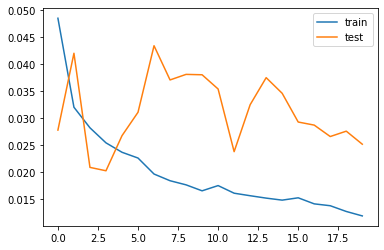

In [0]:
EPOCH = 20
BATCH_size = 72
# design network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# # fit network
history = model.fit(train_X, train_y, epochs=EPOCH, batch_size=BATCH_size, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Evaluate model

In [0]:
test_X.shape[1]

17

In [0]:
# make a prediction
yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: ignored

Input

In [0]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 3], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 3],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [0]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

print ('Single window of past history : {}'.format(x_val_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_val_multi[0].shape))

Single window of past history : (120, 4)

 Target temperature to predict : (72,)
Single window of past history : (120, 4)

 Target temperature to predict : (72,)


Rearrange dataset for TF

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Define function: Plotting a sample data-point & creat_time_steps

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

def create_time_steps(length):
  return list(range(-length, 0))

In this plot and subsequent similar plots, the history and the future data are ampled every hour.


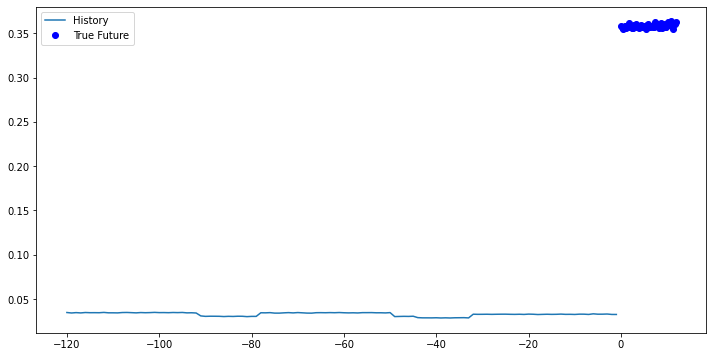

In [0]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
# Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu')) # Add a LSTM layer with 16 internal units.
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.


(256, 72)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 34s 172ms/step - loss: 0.1069 - val_loss: 0.0631
Epoch 2/10
200/200 [==============================] - 31s 156ms/step - loss: 0.0710 - val_loss: 0.0684
Epoch 3/10
200/200 [==============================] - 31s 153ms/step - loss: 0.0632 - val_loss: 0.0639
Epoch 4/10
200/200 [==============================] - 30s 148ms/step - loss: 0.0595 - val_loss: 0.0578
Epoch 5/10
200/200 [==============================] - 31s 156ms/step - loss: 0.0576 - val_loss: 0.0570
Epoch 6/10
200/200 [==============================] - 30s 150ms/step - loss: 0.0545 - val_loss: 0.0511
Epoch 7/10
200/200 [==============================] - 30s 148ms/step - loss: 0.0528 - val_loss: 0.0523
Epoch 8/10
200/200 [==============================] - 31s 157ms/step - loss: 0.0523 - val_loss: 0.0501
Epoch 9/10
200/200 [==============================] - 30s 149ms/step - loss: 0.0505 - val_loss: 0.0482
Epoch 10/10
200/200 

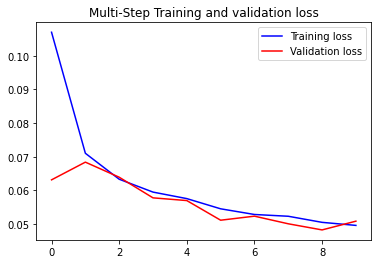

In [0]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

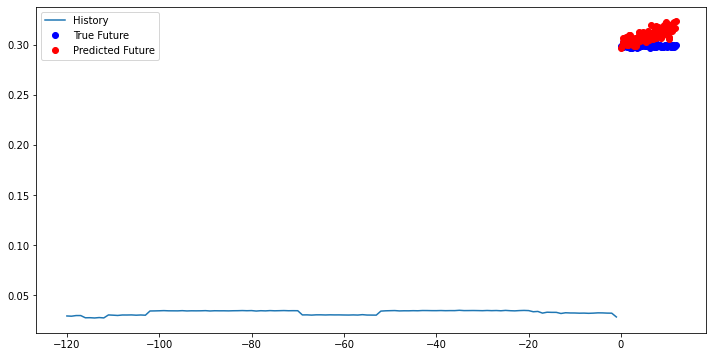

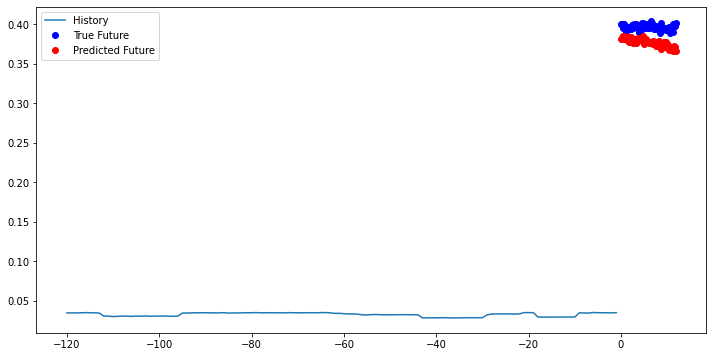

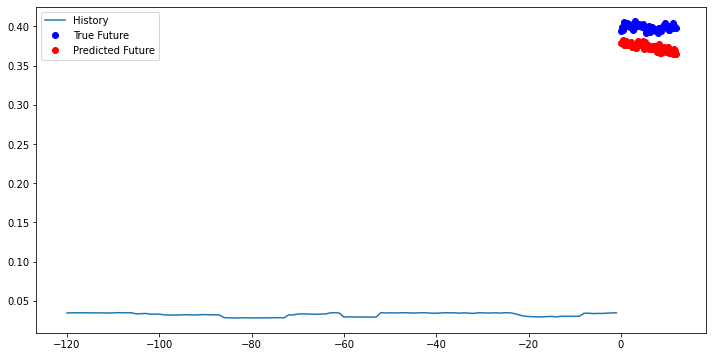

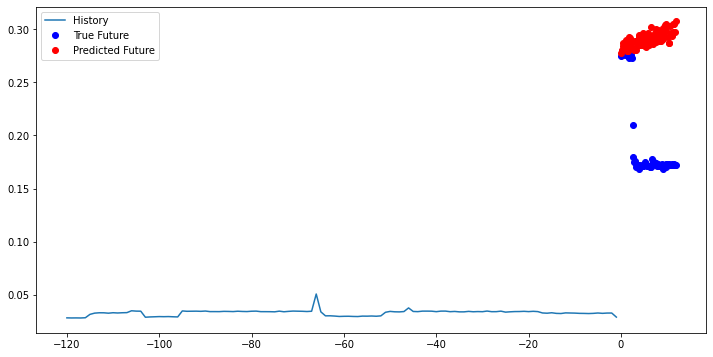

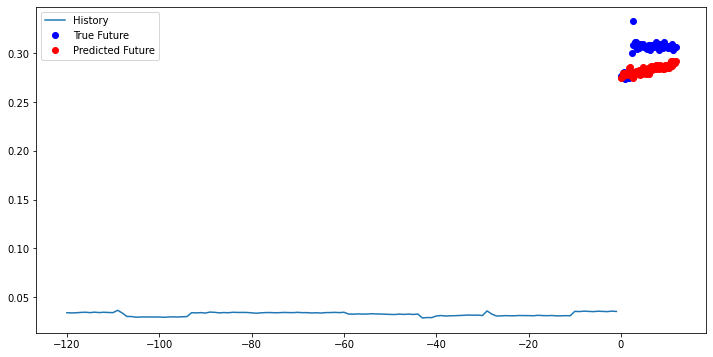

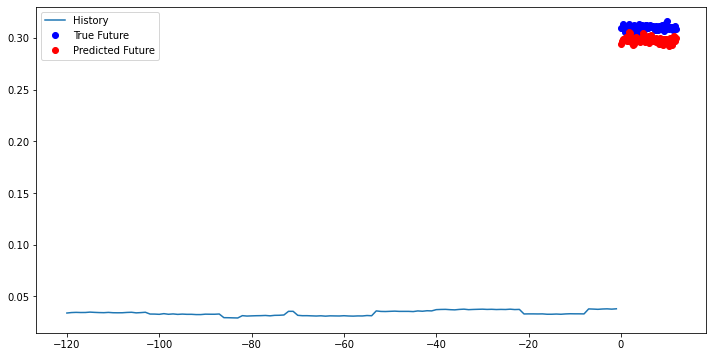

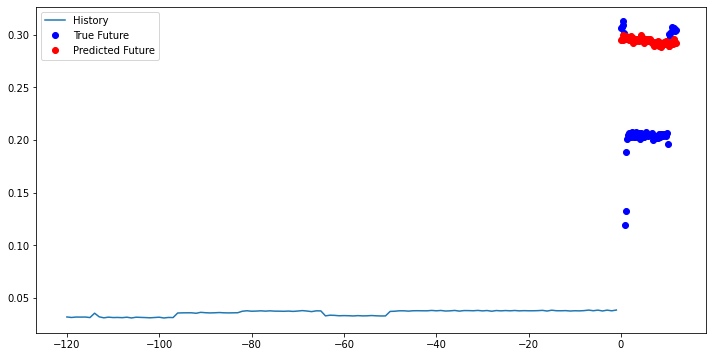

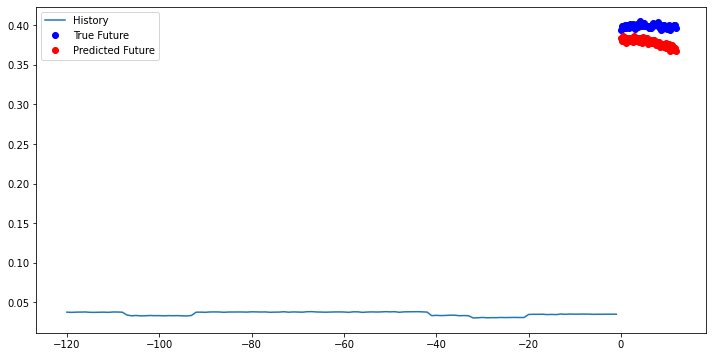

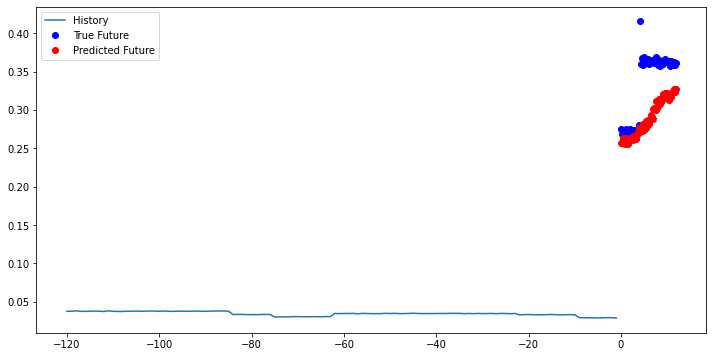

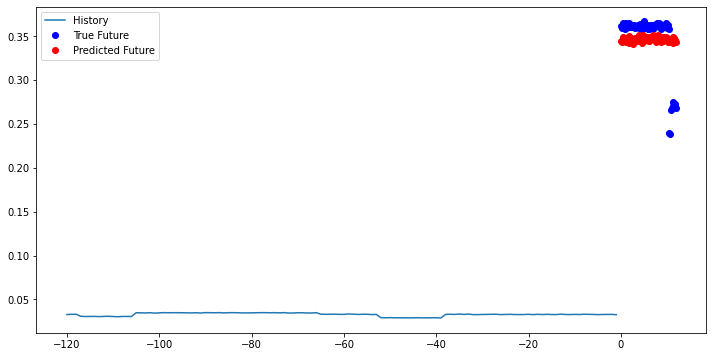

In [0]:

for x, y in val_data_multi.take(EPOCHS):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])